# Costa Rican Household Poverty Level Prediction

Costa Rican Household Poverty Level Prediction is a Kaggle competition which is currently open for late submissions. This competition is for a social cause to help Inter-American Development Bank to identify which households have the highest need for social welfare assistance. Many social programs have a hard time making sure the right people are given enough aid. It’s especially tricky when a program focuses on the poorest segment of the population. The world’s poorest typically can’t provide the necessary income and expense records to prove that they qualify. Other than Costa Rica, many other countries also face this same problem of inaccurately assessing social need. If data scientists can generate an improvement, many countries can take benefit out of it.

The dataset available in Kaggle is a set of household characteristics from a representative sample of Costa Rican Households. The dataset has observations for each member of the household but the classification is done at the household level. This is a multi-class classification problem using a supervised machine learning approach. We classify households according to their income levels (1 = extreme poverty,  2 = moderate poverty, 3 = vulnerable households, 4 = non-vulnerable households). We have identified the multiclass classification algorithms which we think apt to use for this type of problems like, KNN, Logistic Regression, Naive Bayes, Random Forest etc. We will fine-tune the hyperparameters for each model and evaluate the different models using f1-score and accuracy metrics to find out the top best among them. Will do significance tests to figure out the optimal model to perform prediction.

Kaggle competition link:

https://www.kaggle.com/c/costa-rican-household-poverty-prediction (Links to an external site.)Links to an external site.
  

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline.

In [101]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [235]:
# imports
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re
from time import time
from scipy import stats
import json

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Imputer

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

In [103]:
# Imports for metrics
from sklearn.model_selection import cross_val_score, ShuffleSplit
# Imports for stats
from scipy import stats
                       
# Convert a number to a percent.    
def pct(x):
    return round(100*x,1)

# Set up reporting
import pandas as pd
results = pd.DataFrame(columns=["ExpID", "Train Accuracy (Mean)", "Test Accuracy", "p-value", "Train Time(s)", "Test Time(s)", "Experiment description"])

# Set up ShuffleSplit for p_value testing
cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)

# Download the data

The data is located locally within this folder. 

In [104]:
%ls -l all/train.csv

-rw-rw-r-- 1 1000 1000 3237288 Nov 15 09:24 all/train.csv


In [105]:
import pandas as pd

In [106]:
full_train_data = pd.read_csv('all/train.csv')

In [107]:
train_data = pd.read_csv('all/train.csv')
test_data = pd.read_csv('all/test.csv')

# Exploratory Data Analysis

## Training dataset

In [108]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


In [109]:
train_data.dtypes

Id                  object
v2a1               float64
hacdor               int64
rooms                int64
hacapo               int64
v14a                 int64
refrig               int64
v18q                 int64
v18q1              float64
r4h1                 int64
r4h2                 int64
r4h3                 int64
r4m1                 int64
r4m2                 int64
r4m3                 int64
r4t1                 int64
r4t2                 int64
r4t3                 int64
tamhog               int64
tamviv               int64
escolari             int64
rez_esc            float64
hhsize               int64
paredblolad          int64
paredzocalo          int64
paredpreb            int64
pareddes             int64
paredmad             int64
paredzinc            int64
paredfibras          int64
paredother           int64
pisomoscer           int64
pisocemento          int64
pisoother            int64
pisonatur            int64
pisonotiene          int64
pisomadera           int64
t

In [110]:
train_data.shape

(9557, 143)

In [111]:
pd.options.display.max_columns = 150
train_data.head()

Id      v2a1  hacdor  rooms  hacapo  v14a  refrig  v18q  v18q1  \
0  ID_279628684  190000.0       0      3       0     1       1     0    NaN   
1  ID_f29eb3ddd  135000.0       0      4       0     1       1     1    1.0   
2  ID_68de51c94       NaN       0      8       0     1       1     0    NaN   
3  ID_d671db89c  180000.0       0      5       0     1       1     1    1.0   
4  ID_d56d6f5f5  180000.0       0      5       0     1       1     1    1.0   

   r4h1  r4h2  r4h3  r4m1  r4m2  r4m3  r4t1  r4t2  r4t3  tamhog  tamviv  \
0     0     1     1     0     0     0     0     1     1       1       1   
1     0     1     1     0     0     0     0     1     1       1       1   
2     0     0     0     0     1     1     0     1     1       1       1   
3     0     2     2     1     1     2     1     3     4       4       4   
4     0     2     2     1     1     2     1     3     4       4       4   

   escolari  rez_esc  hhsize  paredblolad  paredzocalo  paredpreb  pareddes  \
0        10      NaN       1            1            0          0         0   
1        12      NaN       1            0            0          0         0   
2        11      NaN       1            0            0          0         0   
3         9      1.0       4            1            0          0         0   
4        11      NaN       4            1            0          0         0   

   paredmad  paredzinc  paredfibras  paredother  pisomoscer  pisocemento  \
0         0          0            0           0           1            0   
1         1          0            0           0           0            0   
2         1          0            0           0           1            0   
3         0          0            0           0           1            0   
4         0          0            0           0           1            0   

   pisoother  pisonatur  pisonotiene  pisomadera  techozinc  techoentrepiso  \
0          0          0            0           0          0               1   
1          0          0            0           1          1               0   
2          0          0            0           0          1               0   
3          0          0            0           0          1               0   
4          0          0            0           0          1               0   

   techocane  techootro  cielorazo  abastaguadentro  abastaguafuera  \
0          0          0          1                1               0   
1          0          0          1                1               0   
2          0          0          1                1               0   
3          0          0          1                1               0   
4          0          0          1                1               0   

   abastaguano  public  planpri  noelec  coopele  sanitario1  sanitario2  \
0            0       1        0       0        0           0           1   
1            0       1        0       0        0           0           1   
2            0       1        0       0        0           0           1   
3            0       1        0       0        0           0           1   
4            0       1        0       0        0           0           1   

   sanitario3  sanitario5  sanitario6  energcocinar1  energcocinar2  \
0           0           0           0              0              0   
1           0           0           0              0              1   
2           0           0           0              0              1   
3           0           0           0              0              1   
4           0           0           0              0              1   

   energcocinar3  energcocinar4  elimbasu1  elimbasu2  elimbasu3  elimbasu4  \
0              1              0          1          0          0          0   
1              0              0          1          0          0          0   
2              0              0          1          0          0          0   
3              0              0          1          0

In [112]:
train_data.describe()

v2a1       hacdor        rooms       hacapo         v14a  \
count  2.697000e+03  9557.000000  9557.000000  9557.000000  9557.000000   
mean   1.652316e+05     0.038087     4.955530     0.023648     0.994768   
std    1.504571e+05     0.191417     1.468381     0.151957     0.072145   
min    0.000000e+00     0.000000     1.000000     0.000000     0.000000   
25%    8.000000e+04     0.000000     4.000000     0.000000     1.000000   
50%    1.300000e+05     0.000000     5.000000     0.000000     1.000000   
75%    2.000000e+05     0.000000     6.000000     0.000000     1.000000   
max    2.353477e+06     1.000000    11.000000     1.000000     1.000000   

            refrig         v18q        v18q1         r4h1         r4h2  \
count  9557.000000  9557.000000  2215.000000  9557.000000  9557.000000   
mean      0.957623     0.231767     1.404063     0.385895     1.559171   
std       0.201459     0.421983     0.763131     0.680779     1.036574   
min       0.000000     0.000000     1.000000     0.000000     0.000000   
25%       1.000000     0.000000     1.000000     0.000000     1.000000   
50%       1.000000     0.000000     1.000000     0.000000     1.000000   
75%       1.000000     0.000000     2.000000     1.000000     2.000000   
max       1.000000     1.000000     6.000000     5.000000     8.000000   

              r4h3         r4m1         r4m2         r4m3         r4t1  \
count  9557.000000  9557.000000  9557.000000  9557.000000  9557.000000   
mean      1.945066     0.399184     1.661714     2.060898     0.785079   
std       1.188852     0.692460     0.933052     1.206172     1.047559   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       1.000000     0.000000     1.000000     1.000000     0.000000   
50%       2.000000     0.000000     1.000000     2.000000     0.000000   
75%       3.000000     1.000000     2.000000     3.000000     1.000000   
max       8.000000     6.000000     6.000000     8.000000     7.000000   

              r4t2         r4t3       tamhog       tamviv     escolari  \
count  9557.000000  9557.000000  9557.000000  9557.000000  9557.000000   
mean      3.220885     4.005964     3.999058     4.094590     7.200272   
std       1.440995     1.771202     1.772216     1.876428     4.730877   
min       1.000000     1.000000     1.000000     1.000000     0.000000   
25%       2.000000     3.000000     3.000000     3.000000     4.000000   
50%       3.000000     4.000000     4.000000     4.000000     6.000000   
75%       4.000000     5.000000     5.000000     5.000000    11.000000   
max      11.000000    13.000000    13.000000    15.000000    21.000000   

           rez_esc       hhsize  paredblolad  paredzocalo    paredpreb  \
count  1629.000000  9557.000000  9557.000000  9557.000000  9557.000000   
mean      0.459791     3.999058     0.594015     0.077744     0.188030   
std       0.946550     1.772216     0.491107     0.267782     0.390756   
min       0.000000     1.000000     0.000000     0.000000     0.000000   
25%       0.000000     3.000000     0.000000     0.000000     0.000000   
50%       0.000000     4.000000     1.000000     0.000000     0.000000   
75%       1.000000     5.000000     1.000000     0.000000     0.000000   
max       5.000000    13.000000     1.000000     1.000000     1.000000   

          pareddes     paredmad    paredzinc  paredfibras   paredother  \
count  9557.000000  9557.000000  9557.000000  9557.000000  9557.000000   
mean      0.008580     0.115622     0.013079     0.001465     0.001465   
std       0.092235     0.319788     0.113621     0.038248     0.038248   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

    

In [113]:
train_data.corr()

v2a1    hacdor     rooms    hacapo      v14a    refrig  \
v2a1             1.000000 -0.091732  0.443461 -0.073509  0.033551  0.088970   
hacdor          -0.091732  1.000000 -0.233369  0.652594 -0.175011 -0.101965   
rooms            0.443461 -0.233369  1.000000 -0.213368  0.129183  0.130531   
hacapo          -0.073509  0.652594 -0.213368  1.000000 -0.150986 -0.124506   
v14a             0.033551 -0.175011  0.129183 -0.150986  1.000000  0.143143   
refrig           0.088970 -0.101965  0.130531 -0.124506  0.143143  1.000000   
v18q             0.278364 -0.084680  0.254256 -0.067529  0.036396  0.086002   
v18q1            0.302292 -0.049262  0.208919 -0.037414  0.011255 -0.070318   
r4h1            -0.081900  0.232508 -0.066578  0.226378 -0.054769 -0.047087   
r4h2            -0.002401  0.059313  0.267627  0.126645  0.018133 -0.022819   
r4h3            -0.059548  0.184857  0.195222  0.240056 -0.015552 -0.046860   
r4m1            -0.072791  0.268978 -0.032558  0.241452 -0.006370 -0.023502   
r4m2             0.048169  0.142458  0.241989  0.095545  0.038997  0.027832   
r4m3            -0.007806  0.264620  0.168503  0.212527  0.026510  0.008038   
r4t1            -0.103959  0.328901 -0.064789  0.306722 -0.039803 -0.046136   
r4t2             0.032631  0.134909  0.349206  0.152968  0.038295  0.001607   
r4t3            -0.043574  0.304282  0.245784  0.305857  0.007615 -0.025979   
tamhog          -0.064566  0.304884  0.240137  0.306289  0.007328 -0.026784   
tamviv          -0.051396  0.350948  0.254473  0.354389  0.010613 -0.022060   
escolari         0.288006 -0.122134  0.220284 -0.104846  0.036796  0.097733   
rez_esc         -0.086238  0.047466 -0.084857  0.081574 -0.022039 -0.116235   
hhsize          -0.064566  0.304884  0.240137  0.306289  0.007328 -0.026784   
paredblolad      0.290062 -0.136055  0.260981 -0.126550  0.058186  0.134937   
paredzocalo     -0.101152  0.074927 -0.057740  0.057683 -0.000611 -0.035913   
paredpreb       -0.174037 -0.027202 -0.151392 -0.036119  0.005202  0.022801   
pareddes        -0.037311  0.147449 -0.096855  0.164714 -0.134787 -0.087432   
paredmad        -0.134678  0.083620 -0.111619  0.083705 -0.059958 -0.162714   
paredzinc       -0.053664  0.155120 -0.070527  0.169976  0.008349 -0.053502   
paredfibras     -0.025562 -0.007622 -0.002567 -0.005961  0.002778  0.008057   
paredother      -0.015824 -0.007622 -0.021199 -0.005961  0.002778  0.008057   
pisomoscer       0.296623 -0.168472  0.266992 -0.166538  0.086897  0.169537   
pisocemento     -0.273600  0.077334 -0.203644  0.073848 -0.020410 -0.068315   
pisoother             NaN -0.006109  0.003253 -0.004778  0.002227  0.006459   
pisonatur             NaN  0.078103 -0.040900 -0.005037 -0.221964 -0.073521   
pisonotiene     -0.031581  0.232319 -0.142969  0.256174 -0.059090 -0.099486   
pisomadera      -0.085837  0.055087 -0.076674  0.055785 -0.068411 -0.140878   
techozinc       -0.001022 -0.042053  0.044452 -0.069665  0.063877  0.014877   
techoentrepiso   0.011072 -0.026698 -0.033245 -0.020881  0.009730  0.020343   
techocane       -0.029893 -0.011166  0.002973 -0.008733  0.004070  0.011805   
techootro             NaN -0.009338  0.066864 -0.007303  0.003403  0.009872   
cielorazo        0.300238 -0.177257  0.310513 -0.169545  0.080269  0.171503   
abastaguadentro  0.055717 -0.053838  0.078825 -0.056118  0.151276  0.111854   
abastaguafuera  -0.055717  0.060714 -0.066509  0.062234 -0.119326 -0.083479   
abastaguano           NaN -0.011890 -0.048460 -0.009299 -0.117470 -0.100841   
public           0.121159  0.018548  0.052554 -0.000075  0.014807  0.064289   
planpri               NaN -0.003526 -0.003486 -0.002758  0.001285 -0.025594   
noelec                NaN -0.009338 -0.054890 -0.007303 -0.089524 -0.223078   
coopele         -0.121159 -0.016256 -0.042660  0.002100  0.020980 -0.011786   
sanitario1      -0.027800  0.102032 -0.125488  0.134452 -0.532663 -0.078890   
sanitario2       0.141261 -0.018513  0.076446 -0.032506  0.006009  0.00

### Number of Null Columns.

In [114]:
pd.options.display.max_rows = 150
train_data.isnull().sum()

Id                    0
v2a1               6860
hacdor                0
rooms                 0
hacapo                0
v14a                  0
refrig                0
v18q                  0
v18q1              7342
r4h1                  0
r4h2                  0
r4h3                  0
r4m1                  0
r4m2                  0
r4m3                  0
r4t1                  0
r4t2                  0
r4t3                  0
tamhog                0
tamviv                0
escolari              0
rez_esc            7928
hhsize                0
paredblolad           0
paredzocalo           0
paredpreb             0
pareddes              0
paredmad              0
paredzinc             0
paredfibras           0
paredother            0
pisomoscer            0
pisocemento           0
pisoother             0
pisonatur             0
pisonotiene           0
pisomadera            0
techozinc             0
techoentrepiso        0
techocane             0
techootro             0
cielorazo       

 ### Columns with Null values arranged descending. 

1. rez_esc -- 7928 
2. v18q1   -- 7342
3. v2a1    -- 6860
4. meaneduc -- 5
5. SQBmeaned -- 5
    
    

### Object columns

In [115]:
train_data.select_dtypes('object').head()

Id    idhogar dependency edjefe edjefa
0  ID_279628684  21eb7fcc1         no     10     no
1  ID_f29eb3ddd  0e5d7a658          8     12     no
2  ID_68de51c94  2c7317ea8          8     no     11
3  ID_d671db89c  2b58d945f        yes     11     no
4  ID_d56d6f5f5  2b58d945f        yes     11     no

The Id and idhogar are identifying variables. Values of other columns are a mix of numbers and strings. 

### Target Value counts

In [116]:
train_dat = train_data
train_dat['target_desc'] = train_data['Target']
train_dat['target_desc']=train_dat['target_desc'].apply(str)

In [117]:
train_dat['target_desc'] = train_dat['target_desc'].map({'1': 'extreme poverty' ,'2' : 'moderate poverty', 
                              '3' :'vulnerable households', '4' : 'non vulnerable households'})

In [118]:
train_dat.target_desc.value_counts()

non vulnerable households    5996
moderate poverty             1597
vulnerable households        1209
extreme poverty               755
Name: target_desc, dtype: int64

In [119]:
train_dat.head()

Id      v2a1  hacdor  rooms  hacapo  v14a  refrig  v18q  v18q1  \
0  ID_279628684  190000.0       0      3       0     1       1     0    NaN   
1  ID_f29eb3ddd  135000.0       0      4       0     1       1     1    1.0   
2  ID_68de51c94       NaN       0      8       0     1       1     0    NaN   
3  ID_d671db89c  180000.0       0      5       0     1       1     1    1.0   
4  ID_d56d6f5f5  180000.0       0      5       0     1       1     1    1.0   

   r4h1  r4h2  r4h3  r4m1  r4m2  r4m3  r4t1  r4t2  r4t3  tamhog  tamviv  \
0     0     1     1     0     0     0     0     1     1       1       1   
1     0     1     1     0     0     0     0     1     1       1       1   
2     0     0     0     0     1     1     0     1     1       1       1   
3     0     2     2     1     1     2     1     3     4       4       4   
4     0     2     2     1     1     2     1     3     4       4       4   

   escolari  rez_esc  hhsize  paredblolad  paredzocalo  paredpreb  pareddes  \
0        10      NaN       1            1            0          0         0   
1        12      NaN       1            0            0          0         0   
2        11      NaN       1            0            0          0         0   
3         9      1.0       4            1            0          0         0   
4        11      NaN       4            1            0          0         0   

   paredmad  paredzinc  paredfibras  paredother  pisomoscer  pisocemento  \
0         0          0            0           0           1            0   
1         1          0            0           0           0            0   
2         1          0            0           0           1            0   
3         0          0            0           0           1            0   
4         0          0            0           0           1            0   

   pisoother  pisonatur  pisonotiene  pisomadera  techozinc  techoentrepiso  \
0          0          0            0           0          0               1   
1          0          0            0           1          1               0   
2          0          0            0           0          1               0   
3          0          0            0           0          1               0   
4          0          0            0           0          1               0   

   techocane  techootro  cielorazo  abastaguadentro  abastaguafuera  \
0          0          0          1                1               0   
1          0          0          1                1               0   
2          0          0          1                1               0   
3          0          0          1                1               0   
4          0          0          1                1               0   

   abastaguano  public  planpri  noelec  coopele  sanitario1  sanitario2  \
0            0       1        0       0        0           0           1   
1            0       1        0       0        0           0           1   
2            0       1        0       0        0           0           1   
3            0       1        0       0        0           0           1   
4            0       1        0       0        0           0           1   

   sanitario3  sanitario5  sanitario6  energcocinar1  energcocinar2  \
0           0           0           0              0              0   
1           0           0           0              0              1   
2           0           0           0              0              1   
3           0           0           0              0              1   
4           0           0           0              0              1   

   energcocinar3  energcocinar4  elimbasu1  elimbasu2  elimbasu3  elimbasu4  \
0              1              0          1          0          0          0   
1              0              0          1          0          0          0   
2              0              0          1          0          0          0   
3              0              0          1          0

### Visualization

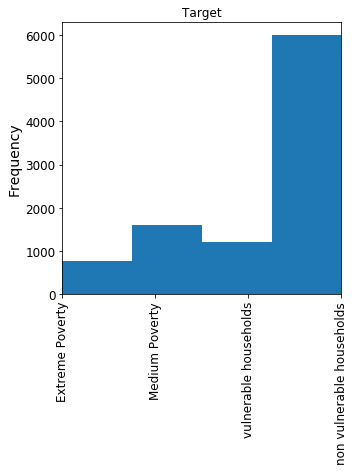

In [120]:
%matplotlib inline
val = ["Extreme Poverty", "Medium Poverty", "vulnerable households", "non vulnerable households"]
import matplotlib.pyplot as plt
train_data.Target.hist(bins=4, figsize=(5,5))
plt.title("Target")
plt.ylabel("Frequency")
plt.xlim([1,4])
plt.xticks([1,2,3,4],val, rotation=90)
#plt.xticks()
plt.grid("off")
plt.show()

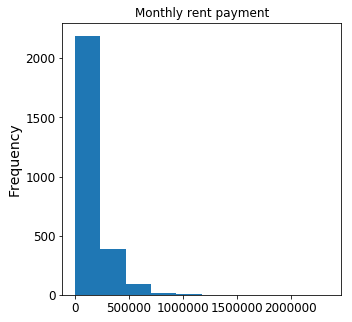

In [121]:
%matplotlib inline
import matplotlib.pyplot as plt
train_data.v2a1.hist(figsize=(5,5))
plt.title("Monthly rent payment")
plt.ylabel("Frequency")
#plt.xticks()
plt.grid("off")
plt.show()

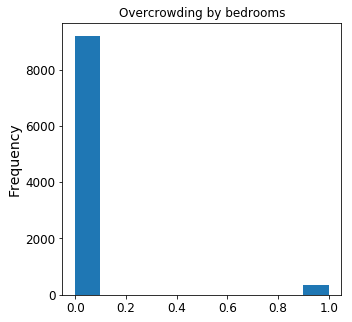

In [122]:
%matplotlib inline
import matplotlib.pyplot as plt
train_data.hacdor.hist(figsize=(5,5))
plt.title("Overcrowding by bedrooms")
plt.ylabel("Frequency")
plt.grid("off")
plt.show()

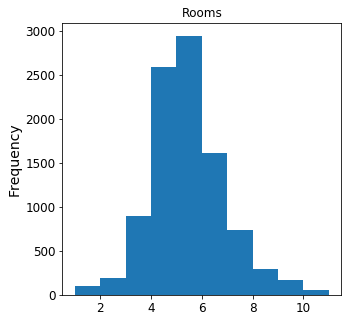

In [123]:
%matplotlib inline
import matplotlib.pyplot as plt
train_data.rooms.hist(figsize=(5,5))
plt.title("Rooms")
plt.ylabel("Frequency")
plt.grid("off")
plt.show()

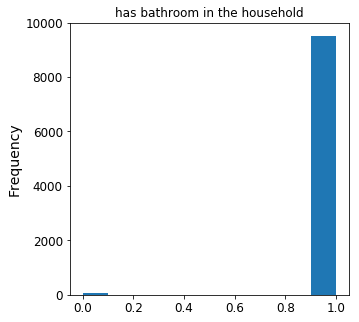

In [124]:
%matplotlib inline
import matplotlib.pyplot as plt
train_data.v14a.hist(figsize=(5,5))
plt.title("has bathroom in the household")
plt.ylabel("Frequency")
plt.grid("off")
plt.show()

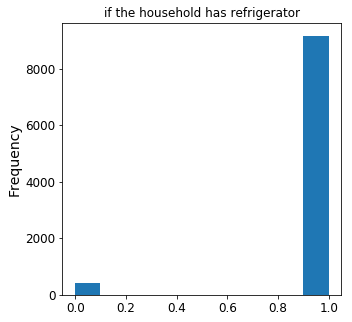

In [125]:
%matplotlib inline
import matplotlib.pyplot as plt
train_data.refrig.hist(figsize=(5,5))
plt.title("if the household has refrigerator")
plt.ylabel("Frequency")
plt.grid("off")
plt.show()

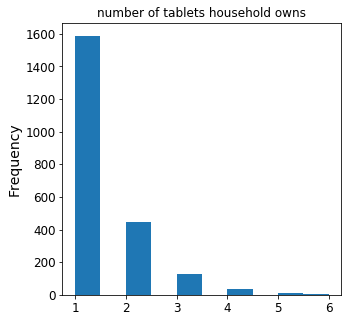

In [126]:
%matplotlib inline
import matplotlib.pyplot as plt
train_data.v18q1.hist(figsize=(5,5))
plt.title("number of tablets household owns")
plt.ylabel("Frequency")
plt.grid("off")
plt.show()

## Test Dataset

In [127]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


In [128]:
test_data.shape

(23856, 142)

In [129]:
pd.options.display.max_columns = 150
test_data.head()

Id      v2a1  hacdor  rooms  hacapo  v14a  refrig  v18q  v18q1  \
0  ID_2f6873615       NaN       0      5       0     1       1     0    NaN   
1  ID_1c78846d2       NaN       0      5       0     1       1     0    NaN   
2  ID_e5442cf6a       NaN       0      5       0     1       1     0    NaN   
3  ID_a8db26a79       NaN       0     14       0     1       1     1    1.0   
4  ID_a62966799  175000.0       0      4       0     1       1     1    1.0   

   r4h1  r4h2  r4h3  r4m1  r4m2  r4m3  r4t1  r4t2  r4t3  tamhog  tamviv  \
0     1     1     2     0     1     1     1     2     3       3       3   
1     1     1     2     0     1     1     1     2     3       3       3   
2     1     1     2     0     1     1     1     2     3       3       3   
3     0     1     1     0     0     0     0     1     1       1       1   
4     0     0     0     0     1     1     0     1     1       1       1   

   escolari  rez_esc  hhsize  paredblolad  paredzocalo  paredpreb  pareddes  \
0         0      NaN       3            1            0          0         0   
1        16      NaN       3            1            0          0         0   
2        17      NaN       3            1            0          0         0   
3        16      NaN       1            1            0          0         0   
4        11      NaN       1            1            0          0         0   

   paredmad  paredzinc  paredfibras  paredother  pisomoscer  pisocemento  \
0         0          0            0           0           1            0   
1         0          0            0           0           1            0   
2         0          0            0           0           1            0   
3         0          0            0           0           1            0   
4         0          0            0           0           1            0   

   pisoother  pisonatur  pisonotiene  pisomadera  techozinc  techoentrepiso  \
0          0          0            0           0          1               0   
1          0          0            0           0          1               0   
2          0          0            0           0          1               0   
3          0          0            0           0          1               0   
4          0          0            0           0          1               0   

   techocane  techootro  cielorazo  abastaguadentro  abastaguafuera  \
0          0          0          1                1               0   
1          0          0          1                1               0   
2          0          0          1                1               0   
3          0          0          1                1               0   
4          0          0          1                1               0   

   abastaguano  public  planpri  noelec  coopele  sanitario1  sanitario2  \
0            0       1        0       0        0           0           1   
1            0       1        0       0        0           0           1   
2            0       1        0       0        0           0           1   
3            0       1        0       0        0           0           1   
4            0       1        0       0        0           0           1   

   sanitario3  sanitario5  sanitario6  energcocinar1  energcocinar2  \
0           0           0           0              0              0   
1           0           0           0              0              0   
2           0           0           0              0              0   
3           0           0           0              0              1   
4           0           0           0              0              1   

   energcocinar3  energcocinar4  elimbasu1  elimbasu2  elimbasu3  elimbasu4  \
0              1              0          1          0          0          0   
1              1              0          1          0          0          0   
2              1              0          1          0          0          0   
3              0              0          1          0

In [130]:
pd.options.display.max_rows = 150
test_data.isnull().sum()

Id                     0
v2a1               17403
hacdor                 0
rooms                  0
hacapo                 0
v14a                   0
refrig                 0
v18q                   0
v18q1              18126
r4h1                   0
r4h2                   0
r4h3                   0
r4m1                   0
r4m2                   0
r4m3                   0
r4t1                   0
r4t2                   0
r4t3                   0
tamhog                 0
tamviv                 0
escolari               0
rez_esc            19653
hhsize                 0
paredblolad            0
paredzocalo            0
paredpreb              0
pareddes               0
paredmad               0
paredzinc              0
paredfibras            0
paredother             0
pisomoscer             0
pisocemento            0
pisoother              0
pisonatur              0
pisonotiene            0
pisomadera             0
techozinc              0
techoentrepiso         0
techocane              0


 ### Columns with Null values arranged descending. 

1. v18q1   -- 18126
2. v2a1    -- 17403
3. meaneduc -- 31
4. SQBmeaned -- 31

# Data Pre-processing

## Handling Missing Data

### v18q1

- v18q -->  owns a tablet
- v18q1 --> number of tablets household owns

- v18q1-- Train data have around 7342 missing values. We can try to compare this missing values with the v18q to see if any of these owns a tablet. If none then we can replace the value directly with 0.


In [131]:
## v18q1  --- This is number of tablet owned by a family.

heads_train = train_data.loc[train_data['parentesco1'] == 1].copy()
heads_train.groupby('v18q')['v18q1'].apply(lambda x: x.isnull().sum())

##This shows that every member have null v18q1 have 0 in v18q. 
##So we can safely replace the nulls with 0



v18q
0    2318
1       0
Name: v18q1, dtype: int64

In [132]:
heads_test = test_data.loc[test_data['parentesco1'] == 1].copy()
heads_test.groupby('v18q')['v18q1'].apply(lambda x: x.isnull().sum())


v18q
0    5726
1       0
Name: v18q1, dtype: int64

In [133]:
train_data['v18q1'] = train_data['v18q1'].fillna(0)
test_data['v18q1'] = test_data['v18q1'].fillna(0)

### rez_esc

- rez_esc --> Years behind school can be filled with 0 

In [134]:
train_data['rez_esc'].describe()

count    1629.000000
mean        0.459791
std         0.946550
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         5.000000
Name: rez_esc, dtype: float64

In [135]:
train_data['rez_esc'] = train_data['rez_esc'].fillna(0)
test_data['rez_esc'] = test_data['rez_esc'].fillna(0)

### v2a1

There could be known reason for missing monthly payment or missing values here. 

- 1. The person can have his own home.We will set the value to 0 for such cases. 
- 2. Other missing due to unknown reason, we will impute the median value within pipeline 



In [136]:
# Fill in households that own the house with 0 rent payment
train_data.loc[(train_data['tipovivi1'] == 1), 'v2a1'] = 0
test_data.loc[(test_data['tipovivi1'] == 1), 'v2a1'] = 0

### meaneduc and SQBmeaned

- meaneduc and SQBmeaned are related. SQBmeaned is the square of meaneduc. Both values are missing for 31 observations and we can impute it with median

### Fill in object columns 

- Fill in string values of below columns with "yes" = 1 and "no" = 0

- dependency: Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)
- edjefe: years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
- edjefa: years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0


In [137]:
map_values = {"yes": 1, "no": 0}

# Fill in the values with the correct mapping
train_data['dependency'] = train_data['dependency'].replace(map_values).astype(np.float64)
train_data['edjefa'] = train_data['edjefa'].replace(map_values).astype(np.float64)
train_data['edjefe'] = train_data['edjefe'].replace(map_values).astype(np.float64)

train_data[['dependency', 'edjefa', 'edjefe']].describe()

dependency       edjefa       edjefe
count  9557.000000  9557.000000  9557.000000
mean      1.149550     2.896830     5.096788
std       1.605993     4.612056     5.246513
min       0.000000     0.000000     0.000000
25%       0.333333     0.000000     0.000000
50%       0.666667     0.000000     6.000000
75%       1.333333     6.000000     9.000000
max       8.000000    21.000000    21.000000

In [138]:
# Fill in the values with the correct mapping
test_data['dependency'] = test_data['dependency'].replace(map_values).astype(np.float64)
test_data['edjefa'] = test_data['edjefa'].replace(map_values).astype(np.float64)
test_data['edjefe'] = test_data['edjefe'].replace(map_values).astype(np.float64)

test_data[['dependency', 'edjefa', 'edjefe']].describe()

dependency        edjefa        edjefe
count  23856.000000  23856.000000  23856.000000
mean       1.181327      2.800176      5.199824
std        1.666209      4.603592      5.200980
min        0.000000      0.000000      0.000000
25%        0.333333      0.000000      0.000000
50%        0.666667      0.000000      6.000000
75%        1.333333      6.000000      9.000000
max        8.000000     21.000000     21.000000

### Label distribution household level

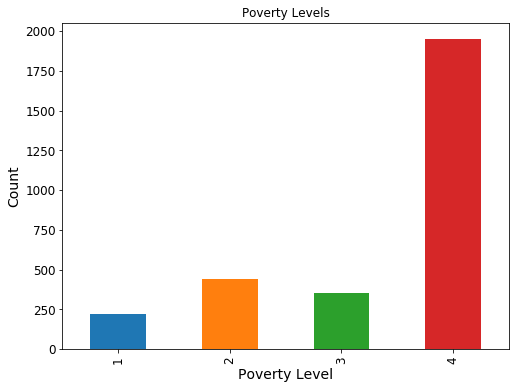

In [141]:
hh_head = train_data.loc[data['parentesco1'] == 1].copy()

train_labels = train_data.loc[(data['Target'].notnull()) & (train_data['parentesco1'] == 1), ['Target', 'idhogar']]

# Value counts of target
target_counts = train_labels['Target'].value_counts().sort_index()

# Bar plot of occurrences of each label
target_counts.plot.bar(figsize = (8, 6), 
                      linewidth = 2)

# Formatting
plt.xlabel('Poverty Level'); plt.ylabel('Count'); 
plt.title('Poverty Levels');


In [142]:
target_counts

1     222
2     442
3     355
4    1954
Name: Target, dtype: int64

#### Identify errors in household data

- Some of the labels are not correct because individuals in the same household have a different poverty level. We can use the head of household as the true label.

In [143]:
# Groupby the household and figure out the number of unique values
equal = train_data.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = equal[equal != True]
len(not_equal)

85

In [144]:
train_data[train_data['idhogar'] == not_equal.index[0]][['idhogar', 'parentesco1', 'Target']]

idhogar  parentesco1  Target
7651  0172ab1d9            0       3
7652  0172ab1d9            0       2
7653  0172ab1d9            0       3
7654  0172ab1d9            1       3
7655  0172ab1d9            0       2

In [145]:
# Iterate through each household
for household in not_equal.index:
    # Find the correct label (for the head of household)
    correct_target = int(train_data[(train_data['idhogar'] == household) & (train_data['parentesco1'] == 1.0)]['Target'])
    
    # Set the correct label for all members in the household
    train_data.loc[train_data['idhogar'] == household, 'Target'] = correct_target
    


# Feature Engineering

We should consolidate our data at a household level. 
We already have some of the information for each household, but for training, we will need all of the information summarized for each household. This means grouping the individuals in a house (groupby) and performing an aggregation (agg) of the individual variables.



The process is as follows

    1.Break variables into household level and invididual level
    2.Find suitable aggregations for the individual level data
        - Ordinal variables can use statistical aggregations
        - Boolean variables can also be aggregated but with fewer stats
    3.Join the individual aggregations to the household level data


There are several different categories of variables:

    1.Individual Variables: these are characteristics of each individual rather than the household
        Boolean: Yes or No (0 or 1)
        Ordered Discrete: Integers with an ordering
    2.Household variables
        Boolean: Yes or No
        Ordered Discrete: Integers with an ordering
        Continuous numeric
    3.Squared Variables: derived from squaring variables in the data
    4.Id variables: identifies the data and should not be used as features


In [147]:
id_fea = ['Id', 'idhogar', 'Target']

In [148]:
ind_bool_fea = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone']

In [149]:
ind_ordered_fea = ['rez_esc', 'escolari', 'age']

In [150]:
hh_bool_fea = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 
           'abastaguadentro', 'abastaguafuera', 'abastaguano',
            'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 
           'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 
           'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
           'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2']

In [151]:
hh_ordered_fea = [ 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

In [152]:
hh_cont_fea = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

In [153]:
sqr_fea = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']


In [154]:
x = ind_bool_fea + ind_ordered_fea + id_fea + hh_bool_fea + hh_ordered_fea + hh_cont_fea + sqr_fea
data = train_data.drop(columns = ['target_desc'])

from collections import Counter

print('No Repeats: ', np.all(np.array(list(Counter(x).values())) == 1))
print('Covered All: ', len(x) == data.shape[1])
print(len(x), data.shape[1])
data.columns

No Repeats:  True
Covered All:  True
143 143


Index(['Id', 'v2a1', 'hacdor', 'rooms', 'hacapo', 'v14a', 'refrig', 'v18q',
       'v18q1', 'r4h1',
       ...
       'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin',
       'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq', 'Target'],
      dtype='object', length=143)

## Remove Squared variables

- Squared variables can be removed from the list of features as original feature is aleady part of the dataset and both are highly correlated

In [155]:
data.shape

(9557, 143)

In [156]:
data = data.drop(columns = sqr_fea)
data.shape

(9557, 134)

## Household level variables

In [157]:
hh_fea = data.loc[data['parentesco1'] == 1, :]
hh_fea = hh_fea[id_fea + hh_bool_fea + hh_cont_fea + hh_ordered_fea]
hh_fea.shape

(2973, 98)

### Remove unnecessary Household Variables

- We can remove highly correlated variables keeping just one out of them.

In [158]:
# Create correlation matrix
corr_matrix = hh_fea.corr()
corr_matrix

Target    hacdor    hacapo      v14a    refrig  \
Target           1.000000 -0.136275 -0.096313  0.068230  0.119607   
hacdor          -0.136275  1.000000  0.624324 -0.143713 -0.055073   
hacapo          -0.096313  0.624324  1.000000 -0.154749 -0.062110   
v14a             0.068230 -0.143713 -0.154749  1.000000  0.192954   
refrig           0.119607 -0.055073 -0.062110  0.192954  1.000000   
paredblolad      0.254469 -0.105112 -0.092562  0.075308  0.132905   
paredzocalo     -0.078851  0.053262  0.036795 -0.011317 -0.047555   
paredpreb       -0.104545 -0.021422 -0.020661  0.001342  0.019826   
pisocemento     -0.209131  0.060396  0.062616 -0.015043 -0.077232   
pareddes        -0.096893  0.139910  0.124520 -0.188425 -0.135424   
paredmad        -0.152979  0.072131  0.066715 -0.057004 -0.134043   
paredzinc       -0.040128  0.101985  0.111904  0.007657 -0.056640   
paredfibras     -0.039861 -0.006039 -0.004544  0.003113  0.009158   
paredother       0.005231 -0.005401 -0.004064  0.002784  0.008190   
pisomoscer       0.275452 -0.130923 -0.124567  0.098117  0.169081   
pisoother        0.016832 -0.003818 -0.002873  0.001968  0.005789   
pisonatur       -0.054463  0.068883 -0.003519 -0.138091 -0.042751   
pisonotiene     -0.114144  0.191171  0.206423 -0.070795 -0.115489   
pisomadera      -0.103487  0.045614  0.032552 -0.105688 -0.125656   
techozinc        0.014357 -0.037777 -0.048015  0.085378  0.029148   
techoentrepiso   0.032872 -0.021824 -0.016422  0.011248  0.022193   
techocane       -0.026240 -0.008108 -0.006101  0.004179  0.012295   
techootro        0.031516 -0.007148 -0.005379  0.003684  0.010840   
cielorazo        0.295249 -0.134352 -0.125825  0.084577  0.162789   
abastaguadentro  0.062961 -0.051855 -0.048910  0.186949  0.137173   
abastaguafuera  -0.046518  0.058215  0.054289 -0.173224 -0.093677   
abastaguano     -0.055818 -0.008967 -0.006747 -0.068852 -0.142789   
public           0.021908  0.015910 -0.008789  0.029051  0.079614   
planpri         -0.009437 -0.003818 -0.002873  0.001968 -0.055245   
noelec          -0.051036 -0.008108 -0.006101 -0.158222 -0.246956   
coopele         -0.007696 -0.013844  0.010760  0.012141 -0.018720   
sanitario1      -0.049932  0.088413  0.122333 -0.624212 -0.185129   
sanitario2       0.097592 -0.006580 -0.022836  0.019500  0.029288   
sanitario3      -0.062316 -0.002880 -0.008292  0.091473  0.045512   
sanitario5      -0.083835 -0.016964  0.041293 -0.030463 -0.141175   
sanitario6      -0.017669 -0.007148 -0.005379  0.003684 -0.054463   
energcocinar1   -0.054739 -0.010478 -0.007884 -0.246445 -0.229800   
energcocinar2    0.158804 -0.050384 -0.044062  0.058683  0.079572   
energcocinar3   -0.083063  0.042438  0.018669 -0.004059  0.021032   
energcocinar4   -0.162796  0.023042  0.063279 -0.046878 -0.161381   
elimbasu1        0.156930 -0.027280 -0.046656  0.042431  0.117560   
elimbasu2       -0.060286  0.001265  0.016337  0.013399 -0.052938   
elimbasu3       -0.142433  0.032345  0.045107 -0.058385 -0.105776   
elimbasu4       -0.041221 -0.005401 -0.004064  0.002784  0.008190   
elimbasu5             NaN       NaN       NaN       NaN       NaN   
elimbasu6        0.023812 -0.005401 -0.004064  0.002784  0.008190   
epared1         -0.208170  0.150762  0.114890 -0.077470 -0.154511   
epared2         -0.162652  0.047898  0.032241 -0.016724 -0.025051   
epared3          0.280947 -0.137802 -0.101011  0.063399  0.118646   
etecho1         -0.209181  0.122137  0.102290 -0.062741 -0.086104   
etecho2         -0.128644  0.038463  0.006424 -0.022349 -0.033812   
etecho3          0.261142 -0.119052 -0.076188  0.063519  0.090036   
eviv1           -0.217908  0.190081  0.193764 -0.066221 -0.131605   
eviv2           -0.174310  0.034392  0.000453 -0.028708 -0.065936   
eviv3            0.293540 -0.149066 -0.120487  0.067141  0.141512   
tipovivi1       -0.022316 -0.064282 -0.034762  0.005645  0.049092   
tipovivi2        0.131069 -0.047444 -0.035699  0.024453  0.055695   
tipovivi3        

In [159]:
# Select upper triangle of correlation matrix
high_cor = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
col_to_drop = [column for column in high_cor.columns if any(abs(high_cor[column]) > 0.95)]

col_to_drop

['coopele', 'area2', 'tamhog', 'hhsize', 'hogar_total']

In [160]:
corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9]

r4t3    tamhog    tamviv    hhsize  hogar_total
r4t3         1.000000  0.996884  0.929237  0.996884     0.996884
tamhog       0.996884  1.000000  0.926667  1.000000     1.000000
tamviv       0.929237  0.926667  1.000000  0.926667     0.926667
hhsize       0.996884  1.000000  0.926667  1.000000     1.000000
hogar_total  0.996884  1.000000  0.926667  1.000000     1.000000

tamviv might not be the same as hhsize because there might be family members that are not living in the household.

In [161]:
hh_fea = hh_fea.drop(columns = ['tamhog', 'hogar_total', 'r4t3'])

### Remove area2

This means the house is in a rural zone, but it's redundant because we have a column indicating if the house is in a urban zone. Therefore, we can drop this column.

In [162]:
hh_fea = hh_fea.drop(columns = 'area2')

### Create new variable 'poor_family'

- Combine No toilet, no electricity, no floor, no water service, no ceiling


In [164]:
# No toilet, no electricity, no floor, no water service, no ceiling
hh_fea['poor_family'] =  (hh_fea['sanitario1'] + 
                         (hh_fea['noelec'] == 1) + 
                         hh_fea['pisonotiene'] + 
                         hh_fea['abastaguano'] + 
                         (hh_fea['cielorazo'] == 0))

In [166]:
hh_fea['poor_family'].tail()

9535    1
9541    2
9545    1
9551    0
9552    0
Name: poor_family, dtype: int64

### Create new variable 'rich_family'

- Create a new variable combining variables for a refrigerator, computer, tablet, or television.

In [167]:
# Owns a refrigerator, computer, tablet, and television
hh_fea['bonus'] =  (hh_fea['refrig'] + 
                      hh_fea['computer'] + 
                      (hh_fea['v18q1'] > 0) + 
                      hh_fea['television'])


## Create per capita variables

In [168]:
hh_fea['phones-per-capita'] = hh_fea['qmobilephone'] / hh_fea['tamviv']
hh_fea['tablets-per-capita'] = hh_fea['v18q1'] / hh_fea['tamviv']
hh_fea['rooms-per-capita'] = hh_fea['rooms'] / hh_fea['tamviv']
hh_fea['rent-per-capita'] = hh_fea['v2a1'] / hh_fea['tamviv']


## Individual level variables

In [169]:
ind_fea = data[id_fea + ind_bool_fea + ind_ordered_fea]
ind_fea.shape

(9557, 39)

In [170]:
# Create correlation matrix
corr_matrix = ind_fea.corr()

# Select upper triangle of correlation matrix
high_cor = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
ind_col_to_drop = [column for column in high_cor.columns if any(abs(high_cor[column]) > 0.95)]

ind_col_to_drop

['female']

This is opposite of male and can be removed

In [171]:
ind_fea = ind_fea.drop(columns = 'male')

### New variable - escolari/age

In [173]:
ind_fea['escolari/age'] = ind_fea['escolari'] / ind_fea['age']
newind = ind_fea

## Aggregate data for household

In order to incorporate the individual data into the household data, we need to aggregate it for each household. The simplest way to do this is to groupby the family id idhogar and then agg the data. For the aggregations for ordered or continuous variables, we can use six, five of which are built in to pandas, and one of which we define ourselves range_. 

In [174]:
# Define custom function
range_ = lambda x: x.max() - x.min()
range_.__name__ = 'range_'

# Group and aggregate
ind_agg = newind.drop(columns = 'Target').groupby('idhogar').agg(['min', 'max', 'sum', 'count', 'std', range_])
ind_agg.head()

v18q                           dis                           female  \
           min max sum count  std range_ min max sum count  std range_    min   
idhogar                                                                         
001ff74ca    1   1   2     2  0.0      0   0   0   0     2  0.0      0      1   
003123ec2    0   0   0     4  0.0      0   0   0   0     4  0.0      0      0   
004616164    0   0   0     2  0.0      0   0   0   0     2  0.0      0      0   
004983866    0   0   0     2  0.0      0   0   0   0     2  0.0      0      0   
005905417    0   0   0     3  0.0      0   0   0   0     3  0.0      0      0   

                                         estadocivil1                          \
          max sum count       std range_          min max sum count       std   
idhogar                                                                         
001ff74ca   1   2     2  0.000000      0            0   1   1     2  0.707107   
003123ec2   1   1     4  0.500000      1            0   1   2     4  0.577350   
004616164   0   0     2  0.000000      0            0   0   0     2  0.000000   
004983866   1   1     2  0.707107      1            0   0   0     2  0.000000   
005905417   1   1     3  0.577350      1            0   1   1     3  0.577350   

                 estadocivil2                               estadocivil3      \
          range_          min max sum count      std range_          min max   
idhogar                                                                        
001ff74ca      1            0   0   0     2  0.00000      0            0   0   
003123ec2      1            0   1   2     4  0.57735      1            0   0   
004616164      0            0   0   0     2  0.00000      0            0   0   
004983866      0            0   0   0     2  0.00000      0            0   0   
005905417      1            0   0   0     3  0.00000      0            0   0   

                                estadocivil4                            \
          sum count  std range_          min max sum count  std range_   
idhogar                                                                  
001ff74ca   0     2  0.0      0            0   0   0     2  0.0      0   
003123ec2   0     4  0.0      0            0   0   0     4  0.0      0   
004616164   0     2  0.0      0            0   0   0     2  0.0      0   
004983866   0     2  0.0      0            0   0   0     2  0.0      0   
005905417   0     3  0.0      0            0   0   0     3  0.0      0   

          estadocivil5                                estadocivil6          \
                   min max sum count       std range_          min max sum   
idhogar                                                                      
001ff74ca            0   1   1     2  0.707107      1            0   0   0   
003123ec2            0   0   0     4  0.000000      0            0   0   0   
004616164            0   0   0     2  0.000000      0            0   1   1   
004983866            0   0   0     2  0.000000      0            0   1   1   
005905417            0   1   1     3  0.577350      1            0   0   0   

                                 estadocivil7                                 \
          count       std range_          min max sum count       std range_   
idhogar                                                                        
001ff74ca     2  0.000000      0            0   0   0     2  0.000000      0   
003123ec2     4  0.000000      0            0   0   0     4  0.000000      0   
004616164     2  0.707107      1            0   1   1     2  0.707107      1   
004983866     2  0.707107      1            0   1   1     2  0.707107      1   
005905417     3  0.000000      0            0   1   1     3  0.577350      1   

          parentesco1                                parentesco2          \
                  min max sum count       std range_         min max sum   
idhogar                                                     

In [175]:
# Rename the columns
ind_new_col = []
for c in ind_agg.columns.levels[0]:
    for stat in ind_agg.columns.levels[1]:
        ind_new_col.append(c+stat)
        


In [176]:
ind_new_col


['v18qmin',
 'v18qmax',
 'v18qsum',
 'v18qcount',
 'v18qstd',
 'v18qrange_',
 'dismin',
 'dismax',
 'dissum',
 'discount',
 'disstd',
 'disrange_',
 'femalemin',
 'femalemax',
 'femalesum',
 'femalecount',
 'femalestd',
 'femalerange_',
 'estadocivil1min',
 'estadocivil1max',
 'estadocivil1sum',
 'estadocivil1count',
 'estadocivil1std',
 'estadocivil1range_',
 'estadocivil2min',
 'estadocivil2max',
 'estadocivil2sum',
 'estadocivil2count',
 'estadocivil2std',
 'estadocivil2range_',
 'estadocivil3min',
 'estadocivil3max',
 'estadocivil3sum',
 'estadocivil3count',
 'estadocivil3std',
 'estadocivil3range_',
 'estadocivil4min',
 'estadocivil4max',
 'estadocivil4sum',
 'estadocivil4count',
 'estadocivil4std',
 'estadocivil4range_',
 'estadocivil5min',
 'estadocivil5max',
 'estadocivil5sum',
 'estadocivil5count',
 'estadocivil5std',
 'estadocivil5range_',
 'estadocivil6min',
 'estadocivil6max',
 'estadocivil6sum',
 'estadocivil6count',
 'estadocivil6std',
 'estadocivil6range_',
 'estadocivil

In [177]:
ind_agg.columns = ind_new_col
ind_agg.head()

v18qmin  v18qmax  v18qsum  v18qcount  v18qstd  v18qrange_  dismin  \
idhogar                                                                        
001ff74ca        1        1        2          2      0.0           0       0   
003123ec2        0        0        0          4      0.0           0       0   
004616164        0        0        0          2      0.0           0       0   
004983866        0        0        0          2      0.0           0       0   
005905417        0        0        0          3      0.0           0       0   

           dismax  dissum  discount  disstd  disrange_  femalemin  femalemax  \
idhogar                                                                        
001ff74ca       0       0         2     0.0          0          1          1   
003123ec2       0       0         4     0.0          0          0          1   
004616164       0       0         2     0.0          0          0          0   
004983866       0       0         2     0.0          0          0          1   
005905417       0       0         3     0.0          0          0          1   

           femalesum  femalecount  femalestd  femalerange_  estadocivil1min  \
idhogar                                                                       
001ff74ca          2            2   0.000000             0                0   
003123ec2          1            4   0.500000             1                0   
004616164          0            2   0.000000             0                0   
004983866          1            2   0.707107             1                0   
005905417          1            3   0.577350             1                0   

           estadocivil1max  estadocivil1sum  estadocivil1count  \
idhogar                                                          
001ff74ca                1                1                  2   
003123ec2                1                2                  4   
004616164                0                0                  2   
004983866                0                0                  2   
005905417                1                1                  3   

           estadocivil1std  estadocivil1range_  estadocivil2min  \
idhogar                                                           
001ff74ca         0.707107                   1                0   
003123ec2         0.577350                   1                0   
004616164         0.000000                   0                0   
004983866         0.000000                   0                0   
005905417         0.577350                   1                0   

           estadocivil2max  estadocivil2sum  estadocivil2count  \
idhogar                                                          
001ff74ca                0                0                  2   
003123ec2                1                2                  4   
004616164                0                0                  2   
004983866                0                0                  2   
005905417                0                0                  3   

           estadocivil2std  estadocivil2range_  estadocivil3min  \
idhogar                                                           
001ff74ca          0.00000                   0                0   
003123ec2          0.57735                   1                0   
004616164          0.00000                   0                0   
004983866          0.00000                   0                0   
005905417          0.00000                   0                0   

           estadocivil3max  estadocivil3sum  estadocivil3count  \
idhogar                                                          
001ff74ca                0                0                  2   
003123ec2                0                0                  4   
004616164                0                0                  2   
004983866                0                0                  2   
005905417                0                0                  3   

      

# Create feature engineering transformer to perform feature transformation and aggregation in a pipeline

In [206]:
from sklearn.base import BaseEstimator, TransformerMixin
col_to_drop = ['coopele', 'area2', 'tamhog', 'hhsize', 'hogar_total']
ind_col_to_drop = ['female']
class FeatureAdder(BaseEstimator, TransformerMixin):
    def __init__(self, features=None): # no *args or **kargs
        self.features = features
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        X = X.drop(columns = sqr_fea)
        hh_fea = X.loc[X['parentesco1'] == 1, :]
        hh_fea = hh_fea[id_fea + hh_bool_fea + hh_cont_fea + hh_ordered_fea]
        hh_fea = hh_fea.drop(columns = ['tamhog', 'hogar_total', 'r4t3'])
        hh_fea = hh_fea.drop(columns = 'area2')
        hh_fea['poor_family'] = (hh_fea['sanitario1'] + 
                         (hh_fea['noelec'] == 1) + 
                         hh_fea['pisonotiene'] + 
                         hh_fea['abastaguano'] + 
                         (hh_fea['cielorazo'] == 0))
        hh_fea['rich_family'] = (hh_fea['refrig'] + 
                      hh_fea['computer'] + 
                      (hh_fea['v18q1'] > 0) + 
                      hh_fea['television'])
        hh_fea['phones-per-capita'] = hh_fea['qmobilephone'] / hh_fea['tamviv']
        hh_fea['tablets-per-capita'] = hh_fea['v18q1'] / hh_fea['tamviv']
        hh_fea['rooms-per-capita'] = hh_fea['rooms'] / hh_fea['tamviv']
        hh_fea['rent-per-capita'] = hh_fea['v2a1'] / hh_fea['tamviv']
        ind_fea = X[id_fea + ind_bool_fea + ind_ordered_fea]
        ind_fea = ind_fea.drop(columns = 'male')
        ind_fea['escolari/age'] = ind_fea['escolari'] / ind_fea['age']
        newind = ind_fea
        # Define custom function
        range_ = lambda x: x.max() - x.min()
        range_.__name__ = 'range_'

        # Group and aggregate
        ind_agg = newind.drop(columns = 'Target').groupby('idhogar').agg(['min', 'max', 'sum', 'count', 'std', range_])

        ind_new_col = []
        ind_new_col = []
        for c in ind_agg.columns.levels[0]:
            for stat in ind_agg.columns.levels[1]:
                ind_new_col.append(c+stat)
        ind_agg.columns = ind_new_col
        corr_matrix = ind_agg.corr()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
        to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]
        ind_agg = ind_agg.drop(columns = to_drop)
        ind_feats = list(ind_agg.columns)
        final = hh_fea.merge(ind_agg, on = 'idhogar', how = 'left')
        return final
   

In [207]:
train_data.shape

(9557, 143)

In [208]:
datafeature = train_data

In [209]:
datafeature.shape

(9557, 143)

In [210]:
dataF = FeatureAdder(datafeature)

In [211]:
finaldataset = dataF.transform(datafeature)

In [212]:
finaldataset.head()

Id    idhogar  Target  hacdor  hacapo  v14a  refrig  paredblolad  \
0  ID_279628684  21eb7fcc1       4       0       0     1       1            1   
1  ID_f29eb3ddd  0e5d7a658       4       0       0     1       1            0   
2  ID_68de51c94  2c7317ea8       4       0       0     1       1            0   
3  ID_ec05b1a7b  2b58d945f       4       0       0     1       1            1   
4  ID_1284f8aad  d6dae86b7       4       1       0     1       1            1   

   paredzocalo  paredpreb  pisocemento  pareddes  paredmad  paredzinc  \
0            0          0            0         0         0          0   
1            0          0            0         0         1          0   
2            0          0            0         0         1          0   
3            0          0            0         0         0          0   
4            0          0            0         0         0          0   

   paredfibras  paredother  pisomoscer  pisoother  pisonatur  pisonotiene  \
0            0           0           1          0          0            0   
1            0           0           0          0          0            0   
2            0           0           1          0          0            0   
3            0           0           1          0          0            0   
4            0           0           1          0          0            0   

   pisomadera  techozinc  techoentrepiso  techocane  techootro  cielorazo  \
0           0          0               1          0          0          1   
1           1          1               0          0          0          1   
2           0          1               0          0          0          1   
3           0          1               0          0          0          1   
4           0          1               0          0          0          1   

   abastaguadentro  abastaguafuera  abastaguano  public  planpri  noelec  \
0                1               0            0       1        0       0   
1                1               0            0       1        0       0   
2                1               0            0       1        0       0   
3                1               0            0       1        0       0   
4                1               0            0       1        0       0   

   coopele  sanitario1  sanitario2  sanitario3  sanitario5  sanitario6  \
0        0           0           1           0           0           0   
1        0           0           1           0           0           0   
2        0           0           1           0           0           0   
3        0           0           1           0           0           0   
4        0           0           1           0           0           0   

   energcocinar1  energcocinar2  energcocinar3  energcocinar4  elimbasu1  \
0              0              0              1              0          1   
1              0              1              0              0          1   
2              0              1              0              0          1   
3              0              1              0              0          1   
4              0              0              1              0          1   

   elimbasu2  elimbasu3  elimbasu4  elimbasu5  elimbasu6  epared1  epared2  \
0          0          0          0          0          0        0        1   
1          0          0          0          0          0        0        1   
2          0          0          0          0          0        0        1   
3          0          0          0          0          0        0        0   
4          0          0          0          0          0        1        0   

   epared3  etecho1  etecho2  etecho3  eviv1  eviv2  eviv3  tipovivi1  \
0        0        1        0        0      1      0      0          0   
1        0        0        1        0      0      1      0          0   
2        0        0        0        1      0      0      1          1   
3        1        0        0        1    

In [213]:
finaldataset.shape

(2973, 215)

In [214]:
test_data.shape
testit = test_data
testit.shape

(23856, 142)

In [309]:
#data_te = FeatureAdder()

In [310]:
#final_test_dataset = data_te.transform(testit)

In [215]:
final1 = finaldataset
final2 = finaldataset
final3 = finaldataset

# Train and validation data split and data preparation

In [216]:
final1.shape

(2973, 215)

In [217]:
final1 = final1.drop(columns=['Id','idhogar'])

In [218]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(final1, final1["Target"]):
    strat_train_set = final1.loc[train_index]
    strat_test_set = final1.loc[test_index]

In [219]:
final1["Target"].value_counts() / len(final1)

4    0.657249
2    0.148671
3    0.119408
1    0.074672
Name: Target, dtype: float64

In [220]:
strat_train_set.shape

(2378, 213)

In [221]:
strat_test_set.shape

(595, 213)

In [222]:
X_train = strat_train_set.drop("Target", axis=1) # drop labels for training set
y_train = strat_train_set["Target"].copy()

In [223]:
X_train.shape

(2378, 212)

In [224]:
y_train.shape

(2378,)

In [225]:
X_test = strat_test_set.drop("Target", axis=1) # drop labels for training set
y_test = strat_test_set["Target"].copy()

In [226]:
X_test.shape

(595, 212)

In [227]:
y_test.shape

(595,)

In [228]:
X_train.head()

hacdor  hacapo  v14a  refrig  paredblolad  paredzocalo  paredpreb  \
2174       0       0     1       1            0            0          1   
1773       0       0     1       1            1            0          0   
1958       0       0     1       1            0            0          1   
2227       0       0     1       1            1            0          0   
1901       0       0     1       1            1            0          0   

      pisocemento  pareddes  paredmad  paredzinc  paredfibras  paredother  \
2174            0         0         0          0            0           0   
1773            1         0         0          0            0           0   
1958            1         0         0          0            0           0   
2227            0         0         0          0            0           0   
1901            0         0         0          0            0           0   

      pisomoscer  pisoother  pisonatur  pisonotiene  pisomadera  techozinc  \
2174           1          0          0            0           0          1   
1773           0          0          0            0           0          1   
1958           0          0          0            0           0          1   
2227           1          0          0            0           0          1   
1901           1          0          0            0           0          1   

      techoentrepiso  techocane  techootro  cielorazo  abastaguadentro  \
2174               0          0          0          0                1   
1773               0          0          0          0                1   
1958               0          0          0          0                1   
2227               0          0          0          1                1   
1901               0          0          0          1                1   

      abastaguafuera  abastaguano  public  planpri  noelec  coopele  \
2174               0            0       1        0       0        0   
1773               0            0       1        0       0        0   
1958               0            0       0        0       0        1   
2227               0            0       1        0       0        0   
1901               0            0       1        0       0        0   

      sanitario1  sanitario2  sanitario3  sanitario5  sanitario6  \
2174           0           0           1           0           0   
1773           0           0           1           0           0   
1958           0           0           1           0           0   
2227           0           0           1           0           0   
1901           0           0           1           0           0   

      energcocinar1  energcocinar2  energcocinar3  energcocinar4  elimbasu1  \
2174              0              0              1              0          1   
1773              0              0              1              0          1   
1958              0              0              0              1          0   
2227              0              0              1              0          1   
1901              0              0              1              0          1   

      elimbasu2  elimbasu3  elimbasu4  elimbasu5  elimbasu6  epared1  epared2  \
2174          0          0          0          0          0        0        1   
1773          0          0          0          0          0        0        0   
1958          0          1          0          0          0        1        0   
2227          0          0          0          0          0        0        0   
1901          0          0          0          0          0        0        0   

      epared3  etecho1  etecho2  etecho3  eviv1  eviv2  eviv3  tipovivi1  \
2174        0        0        1        0      0      1      0          0   
1773        1        0        0        1      0      0      1          0   
1958        0        1        0        0      1      0      0          1   
2227        1        0        0        1      0      0      1          0   


In [229]:
X_train1 = X_train

# Data preparation pipeline

In [230]:
X_train.head()

hacdor  hacapo  v14a  refrig  paredblolad  paredzocalo  paredpreb  \
2174       0       0     1       1            0            0          1   
1773       0       0     1       1            1            0          0   
1958       0       0     1       1            0            0          1   
2227       0       0     1       1            1            0          0   
1901       0       0     1       1            1            0          0   

      pisocemento  pareddes  paredmad  paredzinc  paredfibras  paredother  \
2174            0         0         0          0            0           0   
1773            1         0         0          0            0           0   
1958            1         0         0          0            0           0   
2227            0         0         0          0            0           0   
1901            0         0         0          0            0           0   

      pisomoscer  pisoother  pisonatur  pisonotiene  pisomadera  techozinc  \
2174           1          0          0            0           0          1   
1773           0          0          0            0           0          1   
1958           0          0          0            0           0          1   
2227           1          0          0            0           0          1   
1901           1          0          0            0           0          1   

      techoentrepiso  techocane  techootro  cielorazo  abastaguadentro  \
2174               0          0          0          0                1   
1773               0          0          0          0                1   
1958               0          0          0          0                1   
2227               0          0          0          1                1   
1901               0          0          0          1                1   

      abastaguafuera  abastaguano  public  planpri  noelec  coopele  \
2174               0            0       1        0       0        0   
1773               0            0       1        0       0        0   
1958               0            0       0        0       0        1   
2227               0            0       1        0       0        0   
1901               0            0       1        0       0        0   

      sanitario1  sanitario2  sanitario3  sanitario5  sanitario6  \
2174           0           0           1           0           0   
1773           0           0           1           0           0   
1958           0           0           1           0           0   
2227           0           0           1           0           0   
1901           0           0           1           0           0   

      energcocinar1  energcocinar2  energcocinar3  energcocinar4  elimbasu1  \
2174              0              0              1              0          1   
1773              0              0              1              0          1   
1958              0              0              0              1          0   
2227              0              0              1              0          1   
1901              0              0              1              0          1   

      elimbasu2  elimbasu3  elimbasu4  elimbasu5  elimbasu6  epared1  epared2  \
2174          0          0          0          0          0        0        1   
1773          0          0          0          0          0        0        0   
1958          0          1          0          0          0        1        0   
2227          0          0          0          0          0        0        0   
1901          0          0          0          0          0        0        0   

      epared3  etecho1  etecho2  etecho3  eviv1  eviv2  eviv3  tipovivi1  \
2174        0        0        1        0      0      1      0          0   
1773        1        0        0        1      0      0      1          0   
1958        0        1        0        0      1      0      0          1   
2227        1        0        0        1      0      0      1          0   


In [231]:
columns = X_train.columns

In [232]:
for p in columns:
    print(p)

hacdor
hacapo
v14a
refrig
paredblolad
paredzocalo
paredpreb
pisocemento
pareddes
paredmad
paredzinc
paredfibras
paredother
pisomoscer
pisoother
pisonatur
pisonotiene
pisomadera
techozinc
techoentrepiso
techocane
techootro
cielorazo
abastaguadentro
abastaguafuera
abastaguano
public
planpri
noelec
coopele
sanitario1
sanitario2
sanitario3
sanitario5
sanitario6
energcocinar1
energcocinar2
energcocinar3
energcocinar4
elimbasu1
elimbasu2
elimbasu3
elimbasu4
elimbasu5
elimbasu6
epared1
epared2
epared3
etecho1
etecho2
etecho3
eviv1
eviv2
eviv3
tipovivi1
tipovivi2
tipovivi3
tipovivi4
tipovivi5
computer
television
lugar1
lugar2
lugar3
lugar4
lugar5
lugar6
area1
v2a1
dependency
edjefe
edjefa
meaneduc
overcrowding
rooms
r4h1
r4h2
r4h3
r4m1
r4m2
r4m3
r4t1
r4t2
v18q1
tamviv
hhsize
hogar_nin
hogar_adul
hogar_mayor
bedrooms
qmobilephone
poor_family
rich_family
phones-per-capita
tablets-per-capita
rooms-per-capita
rent-per-capita
v18qmin
v18qsum
v18qcount
v18qstd
v18qrange_
dismin
dismax
dissum
femalem

In [233]:
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [236]:
from sklearn.pipeline import Pipeline, FeatureUnion

# Identify the numeric features we wish to consider. 
num_attribs = ["v2a1",
 "dependency",
 "edjefe",
 "edjefa",
 "meaneduc",
 "overcrowding",
 "rooms",
 "r4h1",
 "r4h2",
 "r4h3",
 "r4m1",
 "r4m2",
 "r4m3",
 "r4t1",
 "r4t2",
 "v18q1",
 "tamviv",
 "hhsize",
 "hogar_nin",
 "hogar_adul",
 "hogar_mayor",
 "bedrooms",
 "qmobilephone",
 "rich_family",
 "poor_family",
 "phones-per-capita",
 "tablets-per-capita",
 "rooms-per-capita",
 "rent-per-capita",
 "v18qmin",
 "v18qsum",
 "v18qcount",
 "v18qstd",
 "v18qrange_",
 "dismin",
 "dismax",
 "dissum",
 "femalemin",
 "femalemax",
 "femalesum",
 "femalestd",
 "femalerange_",
 "estadocivil1min",
 "estadocivil1max",
 "estadocivil1sum",
 "estadocivil2min",
 "estadocivil2max",
 "estadocivil2std",
 "estadocivil3min",
 "estadocivil3max",
 "estadocivil3std",
 "estadocivil4min",
 "estadocivil4max",
 "estadocivil5min",
 "estadocivil5max",
 "estadocivil5sum",
 "estadocivil6min",
 "estadocivil6max",
 "estadocivil7min",
 "estadocivil7max",
 "estadocivil7sum",
 "estadocivil7std",
 "parentesco1min",
 "parentesco1max",
 "parentesco1std",
 "parentesco2min",
 "parentesco2max",
 "parentesco3min",
 "parentesco3max",
 "parentesco3sum",
 "parentesco4min",
 "parentesco4max",
 "parentesco4sum",
 "parentesco5min",
 "parentesco5max",
 "parentesco6min",
 "parentesco6max",
 "parentesco6sum",
 "parentesco7min",
 "parentesco7max",
 "parentesco8min",
 "parentesco8max",
 "parentesco9min",
 "parentesco9max",
 "parentesco9sum",
 "parentesco10min",
 "parentesco10max",
 "parentesco10sum",
 "parentesco11min",
 "parentesco11max",
 "parentesco11sum",
 "parentesco12min",
 "parentesco12max",
 "parentesco12sum",
 "instlevel1min",
 "instlevel1max",
 "instlevel1sum",
 "instlevel2min",
 "instlevel2max",
 "instlevel2sum",
 "instlevel2std",
 "instlevel3min",
 "instlevel3max",
 "instlevel3sum",
 "instlevel3std",
 "instlevel4min",
 "instlevel4max",
 "instlevel4sum",
 "instlevel4std",
 "instlevel5min",
 "instlevel5max",
 "instlevel5sum",
 "instlevel6min",
 "instlevel6max",
 "instlevel6sum",
 "instlevel7min",
 "instlevel7max",
 "instlevel7sum",
 "instlevel8min",
 "instlevel8max",
 "instlevel8sum",
 "instlevel8std",
 "instlevel9min",
 "instlevel9max",
 "mobilephonemin",
 "mobilephonestd",
 "mobilephonerange_",
 "rez_escmin",
 "rez_escmax",
 "escolarimin",
 "escolarimax",
 "escolarisum",
 "escolaristd",
 "escolarirange_",
 "agemin",
 "agemax",
 "agesum",
 "agestd",
 "agerange_",
 "escolari/agemin",
 "escolari/agemax",
 "escolari/agesum",
 "escolari/agestd",
 "escolari/agerange_"]

# Create a pipeline for the numeric features.
# Missing values will be imputed using the feature median.
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

# Identify the categorical features we wish to consider.

cat_attribs = ["edjefe",
 "edjefa",
 "rooms",
 "r4h1",
 "r4h2",
 "r4h3",
 "r4m1",
 "r4m2",
 "r4m3",
 "r4t1",
 "r4t2",
 "v18q1",
 "tamviv",
 "hhsize",
 "hogar_nin",
 "hogar_adul",
 "hogar_mayor",
 "bedrooms",
 "qmobilephone",
 "hacdor",
 "hacapo",
 "v14a",
 "refrig",
 "paredblolad",
 "paredzocalo",
 "paredpreb",
 "pisocemento",
 "pareddes",
 "paredmad",
 "paredzinc",
 "paredfibras",
 "paredother",
 "pisomoscer",
 "pisoother",
 "pisonatur",
 "pisonotiene",
 "pisomadera",
 "techozinc",
 "techoentrepiso",
 "techocane",
 "techootro",
 "cielorazo",
 "abastaguadentro",
 "abastaguafuera",
 "abastaguano",
 "public",
 "planpri",
 "noelec",
 "coopele",
 "sanitario1",
 "sanitario2",
 "sanitario3",
 "sanitario5",
 "sanitario6",
 "energcocinar1",
 "energcocinar2",
 "energcocinar3",
 "energcocinar4",
 "elimbasu1",
 "elimbasu2",
 "elimbasu3",
 "elimbasu4",
 "elimbasu5",
 "elimbasu6",
 "epared1",
 "epared2",
 "epared3",
 "etecho1",
 "etecho2",
 "etecho3",
 "eviv1",
 "eviv2",
 "eviv3",
 "tipovivi1",
 "tipovivi2",
 "tipovivi3",
 "tipovivi4",
 "tipovivi5",
 "computer",
 "television",
 "lugar1",
 "lugar2",
 "lugar3",
 "lugar4",
 "lugar5",
 "lugar6",
 "area1"]

# Create a pipelne for the categorical features.
# Entries with missing values or values that don't exist in the range
# defined above will be one hot encoded as zeroes.
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('imputer', Imputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
    ])



# Feature Selection



In [202]:
finaldataset.head()

Id    idhogar  Target  hacdor  hacapo  v14a  refrig  paredblolad  \
0  ID_279628684  21eb7fcc1       4       0       0     1       1            1   
1  ID_f29eb3ddd  0e5d7a658       4       0       0     1       1            0   
2  ID_68de51c94  2c7317ea8       4       0       0     1       1            0   
3  ID_ec05b1a7b  2b58d945f       4       0       0     1       1            1   
4  ID_1284f8aad  d6dae86b7       4       1       0     1       1            1   

   paredzocalo  paredpreb  pisocemento  pareddes  paredmad  paredzinc  \
0            0          0            0         0         0          0   
1            0          0            0         0         1          0   
2            0          0            0         0         1          0   
3            0          0            0         0         0          0   
4            0          0            0         0         0          0   

   paredfibras  paredother  pisomoscer  pisoother  pisonatur  pisonotiene  \
0            0           0           1          0          0            0   
1            0           0           0          0          0            0   
2            0           0           1          0          0            0   
3            0           0           1          0          0            0   
4            0           0           1          0          0            0   

   pisomadera  techozinc  techoentrepiso  techocane  techootro  cielorazo  \
0           0          0               1          0          0          1   
1           1          1               0          0          0          1   
2           0          1               0          0          0          1   
3           0          1               0          0          0          1   
4           0          1               0          0          0          1   

   abastaguadentro  abastaguafuera  abastaguano  sanitario1  sanitario2  \
0                1               0            0           0           1   
1                1               0            0           0           1   
2                1               0            0           0           1   
3                1               0            0           0           1   
4                1               0            0           0           1   

   sanitario3  sanitario5  sanitario6  energcocinar1  energcocinar2  \
0           0           0           0              0              0   
1           0           0           0              0              1   
2           0           0           0              0              1   
3           0           0           0              0              1   
4           0           0           0              0              0   

   energcocinar3  energcocinar4  elimbasu1  elimbasu2  elimbasu3  elimbasu4  \
0              1              0          1          0          0          0   
1              0              0          1          0          0          0   
2              0              0          1          0          0          0   
3              0              0          1          0          0          0   
4              1              0          1          0          0          0   

   elimbasu5  elimbasu6  epared1  epared2  epared3  etecho1  etecho2  etecho3  \
0          0          0        0        1        0        1        0        0   
1          0          0        0        1        0        0        1        0   
2          0          0        0        1        0        0        0        1   
3          0          0        0        0        1        0        0        1   
4          0          0        1        0        0        1        0        0   

   eviv1  eviv2  eviv3  tipovivi1  tipovivi2  tipovivi3  tipovivi4  tipovivi5  \
0      1      0      0          0          0          1          0          0   
1      0      1      0          0          0          1          0          0   
2      0      0      1          1          0          0          0          0 

In [203]:
corrs = finaldataset.corr()['Target']

In [102]:
corrs.sort_values().head()

instlevel2sum   -0.297868
instlevel1sum   -0.271204
hogar_nin       -0.266309
r4t1            -0.260917
instlevel2max   -0.251575
Name: Target, dtype: float64

## TopFeatureSelector

adding a transformer in the preparation pipeline to select only the most important attributes.

In [294]:
from sklearn.feature_selection import SelectKBest, f_classif
#k is an arbitrary number of features 
#we will use our pipeline below to select based on p values


# SCORE  linear regression input variables using correlation producing F scores and corresponding p-values
# K is used select top k rated input features
def select_kbest_clf(data_frame, target, k):
    """
    Selecting K-Best features regression
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :param k: desired number of features from the data
    :returns feature_scores: scores for each feature in the data as 
    pandas DataFrame
    """
    feat_selector = SelectKBest(f_classif, k=k)
    _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
    
    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.drop(target, axis=1).columns
    
    return feat_scores

In [295]:
X_train.head()

hacdor  hacapo  v14a  refrig  paredblolad  paredzocalo  paredpreb  \
2174       0       0     1       1            0            0          1   
1773       0       0     1       1            1            0          0   
1958       0       0     1       1            0            0          1   
2227       0       0     1       1            1            0          0   
1901       0       0     1       1            1            0          0   

      pisocemento  pareddes  paredmad  paredzinc  paredfibras  paredother  \
2174            0         0         0          0            0           0   
1773            1         0         0          0            0           0   
1958            1         0         0          0            0           0   
2227            0         0         0          0            0           0   
1901            0         0         0          0            0           0   

      pisomoscer  pisoother  pisonatur  pisonotiene  pisomadera  techozinc  \
2174           1          0          0            0           0          1   
1773           0          0          0            0           0          1   
1958           0          0          0            0           0          1   
2227           1          0          0            0           0          1   
1901           1          0          0            0           0          1   

      techoentrepiso  techocane  techootro  cielorazo  abastaguadentro  \
2174               0          0          0          0                1   
1773               0          0          0          0                1   
1958               0          0          0          0                1   
2227               0          0          0          1                1   
1901               0          0          0          1                1   

      abastaguafuera  abastaguano  sanitario1  sanitario2  sanitario3  \
2174               0            0           0           0           1   
1773               0            0           0           0           1   
1958               0            0           0           0           1   
2227               0            0           0           0           1   
1901               0            0           0           0           1   

      sanitario5  sanitario6  energcocinar1  energcocinar2  energcocinar3  \
2174           0           0              0              0              1   
1773           0           0              0              0              1   
1958           0           0              0              0              0   
2227           0           0              0              0              1   
1901           0           0              0              0              1   

      energcocinar4  elimbasu1  elimbasu2  elimbasu3  elimbasu4  elimbasu5  \
2174              0          1          0          0          0          0   
1773              0          1          0          0          0          0   
1958              1          0          0          1          0          0   
2227              0          1          0          0          0          0   
1901              0          1          0          0          0          0   

      elimbasu6  epared1  epared2  epared3  etecho1  etecho2  etecho3  eviv1  \
2174          0        0        1        0        0        1        0      0   
1773          0        0        0        1        0        0        1      0   
1958          0        1        0        0        1        0        0      1   
2227          0        0        0        1        0        0        1      0   
1901          0        0        0        1        0        1        0      0   

      eviv2  eviv3  tipovivi1  tipovivi2  tipovivi3  tipovivi4  tipovivi5  \
2174      1      0          0          1          0          0          0   
1773      0      1          0          0          1          0          0   
1958      0      0          1          0          0          0          0   
2227      0      1

In [296]:
df = tr
df["target"] = y_train
k=10
per_feat = select_kbest_clf(df, 'target', k)

/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 39  97  98 107 128 130 132 135 138 140 143 145 147 150 153 156 177 190
 191 192] are constant.
  UserWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [297]:
per_feat_sorted = per_feat.sort_values(["F Score", "P Value"], ascending=[False, False])
top_k_feature_indices = per_feat_sorted['Attribute'].values.flatten()
print("\n Feature Score for a classifier using correlation\n")
print(per_feat_sorted)   ##INDUS, RM, TAX, PTRATIO, LSAT

print(np.linalg.norm(y_train))


 Feature Score for a classifier using correlation

        F Score       P Value  Support           Attribute
195  148.820649  2.269844e-88     True         escolarimax
68   113.143012  1.773750e-68     True            meaneduc
184   99.631471  9.632479e-61     True       instlevel8max
194   92.521073  1.259081e-56     True         escolarimin
88    88.698646  2.119153e-54     True        less_quality
22    86.312520  5.254417e-53     True           cielorazo
185   84.702083  4.609620e-52     True       instlevel8sum
90    83.782842  1.594992e-51     True   phones-per-capita
49    79.586021  4.687215e-49     True               eviv3
43    76.693619  2.390908e-47     True             epared3
89    75.984457  6.281630e-47    False               bonus
164   75.917346  6.883184e-47    False       instlevel2sum
204   74.120542  7.984371e-46    False     escolari/agemin
186   69.200545  6.724487e-43    False       instlevel8std
46    68.730196  1.282782e-42    False             etecho3
4   

In [298]:
feature_importances = per_feat[["F Score", "Attribute"]] #Order of appearence in dataframe
feature_importances_sorted = per_feat_sorted[["F Score", "Attribute"]] #Order of appearence in dataframe
feature_importances

F Score           Attribute
0     18.147732              hacdor
1      7.996040              hacapo
2      3.472765                v14a
3     12.309060              refrig
4     65.805153         paredblolad
5      5.641257         paredzocalo
6     13.260696           paredpreb
7     39.777308         pisocemento
8      7.877371            pareddes
9     21.837983            paredmad
10     1.452628           paredzinc
11     2.761461         paredfibras
12     0.369292          paredother
13    65.597607          pisomoscer
14     0.173630           pisoother
15     2.689534           pisonatur
16    10.383308         pisonotiene
17     7.313929          pisomadera
18     1.422140           techozinc
19     2.028499      techoentrepiso
20     1.498991           techocane
21     0.870378           techootro
22    86.312520           cielorazo
23     2.744443     abastaguadentro
24     1.686930      abastaguafuera
25     2.671404         abastaguano
26     3.252927          sanitario1
27     9.451944          sanitario2
28     4.393715          sanitario3
29     6.334377          sanitario5
30     0.586614          sanitario6
31     3.703737       energcocinar1
32    21.097569       energcocinar2
33     6.240199       energcocinar3
34    21.266375       energcocinar4
35    19.538389           elimbasu1
36     4.349615           elimbasu2
37    14.789202           elimbasu3
38     3.839684           elimbasu4
39          NaN           elimbasu5
40     0.521557           elimbasu6
41    38.863408             epared1
42    25.106429             epared2
43    76.693619             epared3
44    40.337057             etecho1
45    18.316757             etecho2
46    68.730196             etecho3
47    44.010037               eviv1
48    28.201966               eviv2
49    79.586021               eviv3
50     2.477523           tipovivi1
51    16.009207           tipovivi2
52     1.482811           tipovivi3
53    11.230314           tipovivi4
54     5.688014           tipovivi5
55    30.171196            computer
56    17.751295          television
57    23.880955              lugar1
58     0.732044              lugar2
59     6.195157              lugar3
60     6.948685              lugar4
61     4.184163              lugar5
62     1.043812              lugar6
63     8.462204               area1
64    26.839919                v2a1
65    28.242811          dependency
66    47.994105              edjefe
67     9.394566              edjefa
68   113.143012            meaneduc
69    45.466886        overcrowding
70    32.924074               rooms
71    31.777538                r4h1
72    12.042622                r4h2
73     1.963474                r4h3
74    33.969703                r4m1
..          ...                 ...
134   13.590569      parentesco3sum
135         NaN      parentesco4min
136    3.492656      parentesco4max
137    5.317726      parentesco4sum
138         NaN      parentesco5min
139    0.183197      parentesco5max
140         NaN      parentesco6min
141    8.510882      parentesco6max
142   10.251774      parentesco6sum
143         NaN      parentesco7min
144    0.265382      parentesco7max
145         NaN      parentesco8min
146    0.428287      parentesco8max
147         NaN      parentesco9min
148    0.236740      parentesco9max
149    0.241190      parentesco9sum
150         NaN     parentesco10min
151    0.698114     parentesco10max
152    1.441277     parentesco10sum
153         NaN     parentesco11min
154    0.155246     parentesco11max
155    1.399616     parentesco11sum
156         NaN     parentesco12min
157    1.449379     parentesco12max
158    0.661456     parentesco12sum
159    5.721206       instlevel1min
160   48.958742       instlevel1max
161   62.708509       instlevel1sum
162   12.803202       instlevel2min
163   58.712224       instlevel2max
164   75.917346       instlevel2sum
165   39.711100       instlevel2std
166    1.914821       instlevel3min
167   13.374961       instlevel3max
168   14.291

In [300]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

# Full Pipeline

In [237]:
# Union the transformed, scaled numeric and categorical features.
full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

# Baseline Model

In [239]:
# use full pipeline above to build full pipeline with predictor
from sklearn.feature_selection import SelectKBest
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("feat", SelectKBest(k=20)),
        ("lr", LogisticRegression())
    ])

In [240]:
X_train.shape

(2378, 212)

In [241]:
start = time()
full_pipeline_with_predictor.fit(X_train, y_train)

# Time and score training predictions
cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)
logit_scores = cross_val_score(full_pipeline_with_predictor, X_train, y_train, cv=cv)
logit_score_train = logit_scores.mean()
train_time = np.round(time() - start, 4)

# Time and score test predictions
start = time()
logit_score_test  = full_pipeline_with_predictor.score(X_test, y_test)
test_time = np.round(time() - start, 4)

In [242]:
results.loc[len(results)] = ["Baseline", pct(logit_score_train), pct(logit_score_test), 
                  "---", train_time, test_time, "Untuned LogisticRegression"]
results

ExpID  Train Accuracy (Mean)  Test Accuracy p-value  Train Time(s)  \
0  Baseline                   66.7           66.1     ---         3.6269   

   Test Time(s)      Experiment description  
0        0.0149  Untuned LogisticRegression

# Conduct Grid Search using a variety of Classification Algorithms

In [243]:

# A Function to execute the grid search and record the results.
def ConductGridSearch(X_train, y_train, X_test, y_test, i=0, prefix=''):
    # Create a list of classifiers for our grid search experiment
    classifiers = [
        ('Logistic Regression', LogisticRegression(random_state=42)),
        ('K-Nearest Neighbors', KNeighborsClassifier()),
        ('Naive Bayes', GaussianNB()),
        ('Support Vector', SVC(random_state=42)),
        ('Stochastic GD', SGDClassifier(random_state=42)),
        ('RandomForest', RandomForestClassifier()),
    ]

    # Arrange grid search parameters for each classifier
    params_grid = {
        'Logistic Regression': {
            'penalty': ('l1', 'l2'),
            'tol': (0.0001, 0.00001, 0.0000001), 
            'C': (10, 1, 0.1, 0.01),
        },
        'K-Nearest Neighbors': {
            'n_neighbors': (3, 5, 7, 8, 11),
            'p': (1,2),
        },
        'Naive Bayes': {},
        'Support Vector' : {
            'kernel': ('rbf', 'poly'),     
            'degree': (1, 2, 3, 4, 5),
            'C': (10, 1, 0.1, 0.01),
        },
        'Stochastic GD': {
            'loss': ('hinge', 'perceptron', 'log'),
            'penalty': ('l1', 'l2', 'elasticnet'),
            'tol': (0.0001, 0.00001, 0.0000001), 
            'alpha': (0.1, 0.01, 0.001, 0.0001), 
        },
        'RandomForest':  {
            'max_depth': [9, 15, 22, 26, 30],
            'max_features': [1, 3, 5],
            'min_samples_split': [5, 10, 15],
            'min_samples_leaf': [3, 5, 10],
            'bootstrap': [False],
            'n_estimators':[20, 80, 150, 200, 300]},
    }
    
    for (name, classifier) in classifiers:
        i += 1
        # Print classifier and parameters
        print('****** START',prefix, name,'*****')
        parameters = params_grid[name]
        print("Parameters:")
        for p in sorted(parameters.keys()):
            print("\t"+str(p)+": "+ str(parameters[p]))
        
        # generate the pipeline
        full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("feat", SelectKBest(k='all')),
        ("predictor", classifier)
        ])
        
        # Execute the grid search
        params = {}
        for p in parameters.keys():
            pipe_key = 'predictor__'+str(p)
            params[pipe_key] = parameters[p] 
            
        grid_search = GridSearchCV(full_pipeline_with_predictor, params, scoring='accuracy', cv=5, verbose=1)
        grid_search.fit(X_train, y_train)
                
        # Best estimator score
        best_train = pct(grid_search.best_score_)

        # Best estimator fitting time
        start = time()
        grid_search.best_estimator_.fit(X_train, y_train)
        train_time = round(time() - start, 4)

        # Best estimator prediction time
        start = time()
        best_test_accuracy = pct(grid_search.best_estimator_.score(X_test, y_test))
        test_time = round(time() - start, 4)

        # Generate 30 training accuracy scores with the best estimator and 30-split CV
        best_train_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=cv)
        best_train_accuracy = pct(best_train_scores.mean())

        # Conduct t-test with baseline logit (control) and best estimator (experiment)
        (t_stat, p_value) = stats.ttest_rel(logit_scores, best_train_scores)
        
        # Collect the best parameters found by the grid search
        print("Best Parameters:")
        best_parameters = grid_search.best_estimator_.get_params()
        param_dump = []
        for param_name in sorted(params.keys()):
            param_dump.append((param_name, best_parameters[param_name]))
            print("\t"+str(param_name)+": " + str(best_parameters[param_name]))
        print("****** FINISH",prefix,name," *****")
        print("")
        
        # Record the results
        results.loc[i] = [prefix+name, best_train_accuracy, best_test_accuracy, round(p_value,3), train_time, test_time, json.dumps(param_dump)]

In [244]:
%%time
# This might take a while
ConductGridSearch(X_train, y_train, X_test, y_test, 0, "Best Model:")

****** START Best Model: Logistic Regression *****
Parameters:
	C: (10, 1, 0.1, 0.01)
	penalty: ('l1', 'l2')
	tol: (0.0001, 1e-05, 1e-07)
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 17.7min finished


Best Parameters:
	predictor__C: 0.01
	predictor__penalty: l2
	predictor__tol: 0.0001
****** FINISH Best Model: Logistic Regression  *****

****** START Best Model: K-Nearest Neighbors *****
Parameters:
	n_neighbors: (3, 5, 7, 8, 11)
	p: (1, 2)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.6min finished


Best Parameters:
	predictor__n_neighbors: 11
	predictor__p: 2
****** FINISH Best Model: K-Nearest Neighbors  *****

****** START Best Model: Naive Bayes *****
Parameters:
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished


Best Parameters:
****** FINISH Best Model: Naive Bayes  *****

****** START Best Model: Support Vector *****
Parameters:
	C: (10, 1, 0.1, 0.01)
	degree: (1, 2, 3, 4, 5)
	kernel: ('rbf', 'poly')
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 11.0min finished


Best Parameters:
	predictor__C: 10
	predictor__degree: 1
	predictor__kernel: poly
****** FINISH Best Model: Support Vector  *****

****** START Best Model: Stochastic GD *****
Parameters:
	alpha: (0.1, 0.01, 0.001, 0.0001)
	loss: ('hinge', 'perceptron', 'log')
	penalty: ('l1', 'l2', 'elasticnet')
	tol: (0.0001, 1e-05, 1e-07)
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  5.2min finished


Best Parameters:
	predictor__alpha: 0.1
	predictor__loss: log
	predictor__penalty: l2
	predictor__tol: 0.0001
****** FINISH Best Model: Stochastic GD  *****

****** START Best Model: RandomForest *****
Parameters:
	bootstrap: [False]
	max_depth: [9, 15, 22, 26, 30]
	max_features: [1, 3, 5]
	min_samples_leaf: [3, 5, 10]
	min_samples_split: [5, 10, 15]
	n_estimators: [20, 80, 150, 200, 300]
Fitting 5 folds for each of 675 candidates, totalling 3375 fits


[Parallel(n_jobs=1)]: Done 3375 out of 3375 | elapsed: 27.6min finished


Best Parameters:
	predictor__bootstrap: False
	predictor__max_depth: 15
	predictor__max_features: 5
	predictor__min_samples_leaf: 3
	predictor__min_samples_split: 10
	predictor__n_estimators: 200
****** FINISH Best Model: RandomForest  *****

CPU times: user 1h 27min 38s, sys: 1min 56s, total: 1h 29min 35s
Wall time: 1h 6min 13s


In [246]:
results

ExpID  Train Accuracy (Mean)  Test Accuracy  \
0                        Baseline                   66.7           66.1   
1  Best Model:Logistic Regression                   67.7           68.7   
2  Best Model:K-Nearest Neighbors                   66.5           64.7   
3          Best Model:Naive Bayes                   19.6           19.2   
4       Best Model:Support Vector                   67.4           67.2   
5        Best Model:Stochastic GD                   67.8           68.2   
6         Best Model:RandomForest                   67.4           67.4   

  p-value  Train Time(s)  Test Time(s)  \
0     ---         3.6269        0.0149   
1       0         0.5882        0.0105   
2   0.633         0.1542        1.1371   
3       0         0.0986        0.0194   
4   0.002         2.4390        0.3861   
5       0         0.2796        0.0105   
6       0         0.7504        0.0627   

                              Experiment description  
0                         Untuned LogisticRegression  
1  [["predictor__C", 0.01], ["predictor__penalty"...  
2  [["predictor__n_neighbors", 11], ["predictor__...  
3                                                 []  
4  [["predictor__C", 10], ["predictor__degree", 1...  
5  [["predictor__alpha", 0.1], ["predictor__loss"...  
6  [["predictor__bootstrap", false], ["predictor_...

# Significance test of best models

In [ ]:
# Compare Algorithms
from pandas import read_csv
from matplotlib import pyplot
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
#Standardize the data
for name, model in models:
    kfold = KFold(n_splits=5, random_state=7)
    cv_results = cross_val_score(model, x_train_prepared, y_train, cv=kfold, scoring=scoring)
    print(cv_results)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
resultscv = results
print(resultscv)
fig = pyplot.figure()
fig.suptitle('Classification Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.grid()
pyplot.show()